In [27]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pickle
import random
from copy import copy, deepcopy
from scipy.io import arff
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import pdist, cdist
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances
from sklearn.utils import check_random_state
from scipy.spatial import distance
from tslearn.soft_dtw_fast import *
from tslearn.cysax import *
from tslearn.metrics import dtw, dtw_path,dtw_path_from_metric,soft_dtw
from tslearn.utils import *


# Loading Training and Testing Data Source

In [2]:
data1 = arff.loadarff('/Users/arslanaliawan/Desktop/Pre-experiment/Multivariate_arff/CharacterTrajectories/CharacterTrajectoriesDimension1_TRAIN.arff')
data2 = arff.loadarff('/Users/arslanaliawan/Desktop/Pre-experiment/Multivariate_arff/CharacterTrajectories/CharacterTrajectoriesDimension2_TRAIN.arff')
data3 = arff.loadarff('/Users/arslanaliawan/Desktop/Pre-experiment/Multivariate_arff/CharacterTrajectories/CharacterTrajectoriesDimension3_TRAIN.arff')

Test_data1 = arff.loadarff('/Users/arslanaliawan/Desktop/Pre-experiment/Multivariate_arff/CharacterTrajectories/CharacterTrajectoriesDimension1_TEST.arff')
Test_data2 = arff.loadarff('/Users/arslanaliawan/Desktop/Pre-experiment/Multivariate_arff/CharacterTrajectories/CharacterTrajectoriesDimension2_TEST.arff')
Test_data3 = arff.loadarff('/Users/arslanaliawan/Desktop/Pre-experiment/Multivariate_arff/CharacterTrajectories/CharacterTrajectoriesDimension3_TEST.arff')

In [3]:
df_D1 = pd.DataFrame(data1[0])
df_D2 = pd.DataFrame(data2[0])
df_D3 = pd.DataFrame(data3[0])

Test_df_D1 = pd.DataFrame(Test_data1[0])
Test_df_D2 = pd.DataFrame(Test_data2[0])
Test_df_D3 = pd.DataFrame(Test_data3[0])

## Make Over the data, as desired

In [4]:
df_D1 =df_D1.apply(lambda x : x.fillna(method='ffill'), axis=1) 
df_D2 =df_D2.apply(lambda x : x.fillna(method='ffill'), axis=1)
df_D3 =df_D3.apply(lambda x : x.fillna(method='ffill'), axis=1) 

Test_df_D1 =Test_df_D1.apply(lambda x : x.fillna(method='ffill'), axis=1) 
Test_df_D2 =Test_df_D2.apply(lambda x : x.fillna(method='ffill'), axis=1)
Test_df_D3 =Test_df_D3.apply(lambda x : x.fillna(method='ffill'), axis=1) 

In [5]:
df_D1 = df_D1.drop('target', axis=1)
df_D2 = df_D2.drop('target', axis=1)
df_D3 = df_D3.drop('target', axis=1)

Test_df_D1 = Test_df_D1.drop('target', axis=1)
Test_df_D2 = Test_df_D2.drop('target', axis=1)
Test_df_D3 = Test_df_D3.drop('target', axis=1)

In [6]:
Sort_Dim_1 = np.expand_dims(df_D1.values.reshape(-1),axis=1)
Sort_Dim_2 = np.expand_dims(df_D2.values.reshape(-1),axis=1)
Sort_Dim_3 = np.expand_dims(df_D3.values.reshape(-1),axis=1)

Sort_Test_Dim_1 = np.expand_dims(Test_df_D1.values.reshape(-1),axis=1)
Sort_Test_Dim_2 = np.expand_dims(Test_df_D2.values.reshape(-1),axis=1)
Sort_Test_Dim_3 = np.expand_dims(Test_df_D3.values.reshape(-1),axis=1)

In [7]:
Training_View = np.concatenate((Sort_Dim_1, Sort_Dim_2),axis=1)
Training_View = np.concatenate((Training_View, Sort_Dim_3),axis=1)

In [8]:
Training_View.shape

(258804, 3)

In [9]:
Testing_View = np.concatenate((Sort_Test_Dim_1, Sort_Test_Dim_2),axis=1)
Testing_View = np.concatenate((Testing_View, Sort_Test_Dim_3),axis=1)

In [10]:
finalarray_test_data = Testing_View[:][0:182]

In [11]:
finalarray_test_data.shape

(182, 3)

## Initializing the data

In [47]:
Total_rows = 258804
Sample_Percentage = 0
Number_of_run= 0
Length_RTS = 0
global Sub_Sample_copy_PTS 
Training_Results_List = []
PTS_Results_List = []
Store_Avg_list = []
dictionary = dict()
dictionary_RTS = dict()
dictionary_PTS = dict()
RTS_short_list_Results_List = []
Starting_point = Testing_View[:][0:1]
End_point = Testing_View[:][181:182]

## Functions body for Random TS

In [40]:
def generate_random_number_for_RTS():
    num = random.randint(50, 120)
    return num

In [13]:
def Calculate_Percentage(Sample_Percentage):
    Refining_Percentage= Total_rows * (Sample_Percentage/100)
    Refining_Percentage = round(Refining_Percentage)   
    return Refining_Percentage

In [14]:
def Random_Part(Refining_Percentage):
    Sub_Sampling = Training_View[:][0:Refining_Percentage]
    return Sub_Sampling

    

In [15]:
def Get_random_row(Sub_Sampling,Length_RTS):
    
    number_of_rows = Sub_Sampling.shape[0]
    random_indices = np.random.choice(number_of_rows, size=Length_RTS, replace=False)
    random_rows = Sub_Sampling[random_indices, :]
    return random_rows
    

In [16]:
def Adding_start_end_point(random_rows):
    Output_TS = np.concatenate((Starting_point, random_rows),axis=0)
    Output_TS = np.concatenate((Output_TS, End_point),axis=0)
    return Output_TS

In [26]:
def Calculate_Random_DTW(Output_TS,Len_RTS):
    path, dist = dtw_path(finalarray_test_data, Output_TS)
    if(dist>0 and Len_RTS >150 ):
        
        Training_Results_List.append(dist)  
    else:
        RTS_short_list_Results_List.append(dist)

## Functions body for Pseudo TS

In [18]:
def generate_similarity_matrix(Complete_PTS):
    ED_Matrix = distance.cdist(Complete_PTS, Complete_PTS, 'euclidean')
    return ED_Matrix

In [19]:
def generate_graph(similarity_output):
    G = nx.from_numpy_matrix(similarity_output, create_using=nx.Graph)
    layout = nx.spring_layout(G)
    sizes = len(similarity_output)
    return G

In [20]:
def generate_MST(G):
    layout = nx.spring_layout(G)
    T=nx.minimum_spanning_tree(G)
    return T

In [21]:
def generate_Dijkstra(T):
    Dij = nx.dijkstra_path(T,0,181)
    return Dij

In [22]:
def doing_miscellaneous_work(Dijkstra_output):
    a = []
    for x in range(len(Dijkstra_output)):
    
        Index = Dijkstra_output[x]
        a.append(list(Complete_PTS[Index]))
    P_TS = np.array(a)
    return P_TS

In [23]:
def generate_DTW_PTS(Miscellaneous_output):
    path, dist = dtw_path(finalarray_test_data, Miscellaneous_output)
    if(dist>0):
        PTS_Results_List.append(dist)     

In [24]:
def Adding_start_end_point_PTS(Pseudo_TS,y):
    if(y==1):
        SP = [Testing_View[:][0]]
        EP = [Testing_View[:][181]]
        Output_PTS = np.concatenate((SP, Pseudo_TS),axis=0)
        Output_PTS = np.concatenate((Output_PTS, EP),axis=0)
    else:
        p =182
        SP = [Testing_View[:][p*(y-1)]]
        EP = [Testing_View[:][((y*p)-1)]]
        Output_PTS = np.concatenate((SP, Pseudo_TS),axis=0)
        Output_PTS = np.concatenate((Output_PTS, EP),axis=0)
    return Output_PTS

In [25]:
def Run_all_fun(Complete_PTS):
    similarity_output = generate_similarity_matrix(Complete_PTS)
    graph_output = generate_graph(similarity_output)
    MST_output_1 =  generate_MST(graph_output)
    Dijkstra_output = generate_Dijkstra(MST_output_1)
    Miscellaneous_output = doing_miscellaneous_work(Dijkstra_output)
    generate_DTW_PTS(Miscellaneous_output)

### Running Part for RTS with Number of iterations ; different percentage ; Diff. length of RTS

In [41]:
for i in range (10):
    random_num_out = generate_random_number_for_RTS()
    for x in range(1,6):
        
        Refining_Percentage = Calculate_Percentage(20*x)
        Sub_Sampling = Random_Part(Refining_Percentage)
        random_rows = Get_random_row(Sub_Sampling,random_num_out)
        Output_TS = Adding_start_end_point(random_rows)
        Calculate_Random_DTW(Output_TS,random_num_out) 
    dictionary_RTS[i] = RTS_short_list_Results_List
    RTS_short_list_Results_List= []

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe824efad90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe824f08810>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe824efa0d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe824efae50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe824f0e790>],
 'means': []}

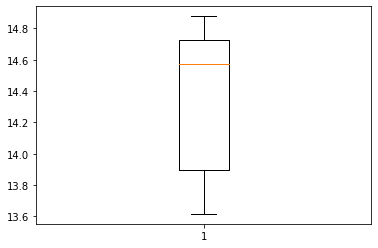

In [43]:
# for i in range(10):
plt.boxplot(dictionary_RTS[7]) 
    


### Running Part for RTS with Number of iterations ; different percentage

In [44]:
for i in range (10):

    for x in range(1,6):
        
        Refining_Percentage = Calculate_Percentage(20*x)
        Sub_Sampling = Random_Part(Refining_Percentage)
        random_rows = Get_random_row(Sub_Sampling,180)
        Output_TS = Adding_start_end_point(random_rows)
        Calculate_Random_DTW(Output_TS,180) 
    dictionary_RTS[i] = Training_Results_List
    Training_Results_List= []

###  ------------------------------------------

## Changing SP and EP of Training TS  for Pseudo TS

In [72]:
for y in range(1,11):
    for x in range(1,6):
        
        Refining_Percentage = Calculate_Percentage(20*x)
        Sub_Sampling = Random_Part(Refining_Percentage)
        Sub_Sampling_PTS = Sub_Sampling[:][1:181]
        Pseudo_TS = Sub_Sampling_PTS
        Complete_PTS = Adding_start_end_point_PTS(Pseudo_TS,y)
        Run_all_fun(Complete_PTS) 

            
    dictionary_PTS[y] = PTS_Results_List
    PTS_Results_List = []





### Changing whole Training TS with SP and EP for PTS

In [71]:
# for y in range(1,11):
#     for x in range(1,6):
#         i = 181
#         if(x==1):
#             Refining_Percentage = Calculate_Percentage(20*x)
#             Sub_Sampling = Random_Part(Refining_Percentage)
#             Sub_Sampling_PTS = Sub_Sampling[:][1:181*x]
#             Pseudo_TS = Sub_Sampling_PTS
#             Complete_PTS = Adding_start_end_point_PTS(Pseudo_TS,y)
#             Run_all_fun(Complete_PTS) 

#         else:
#             Refining_Percentage = Calculate_Percentage(20*x)
#             Sub_Sampling = Random_Part(Refining_Percentage)
#             Sub_Sampling_PTS = Sub_Sampling[:][1+i:181*x]
#             Pseudo_TS = Sub_Sampling_PTS
#             Complete_PTS = Adding_start_end_point_PTS(Pseudo_TS,y)
#             Run_all_fun(Complete_PTS) 
            
#     dictionary_PTS[y] = PTS_Results_List
#     PTS_Results_List = []